<a href="https://colab.research.google.com/github/xfo-03/Hierarchical_Classification_of_Articles/blob/main/English_XLM_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import re
import numpy as np



In [ ]:
from google.colab import auth
auth.authenticate_user()


MessageError: Error: credential propagation was unsuccessful

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preprocessing:

Preprocessing articles
Preprocessing the annotations and merging with the article.
Taxonomies Classification
One Hot embedding
Encode Multi Class Labels

### Preprocessing

In [ ]:
import pandas as pd
import os

def preprocess_articles(article_dir):
    """
    Preprocess the article files by extracting filenames and text content into a DataFrame.

    Args:
    - article_dir (str): Directory path containing article `.txt` files.

    Returns:
    - pandas.DataFrame: DataFrame with columns ['article_id', 'text'].
    """
    # List to store article data
    articles = []

    # Loop through each file in the directory
    for filename in os.listdir(article_dir):
        if filename.endswith(".txt"):
            file_path = os.path.join(article_dir, filename)

            # Read the file content
            with open(file_path, 'r', encoding='utf-8') as file:
                lines = file.readlines()

                # Extract the text: skip title (first row) and empty line (second row)
                title = lines[0].strip() if len(lines) > 0 else ""
                content = " ".join(line.strip() for line in lines[2:])

                # Append the extracted data
                articles.append({'article_id': filename, 'text': title + "\n" + content})

    # Create a DataFrame
    article_df = pd.DataFrame(articles)

    return article_df

# Preprocessing the annotations and merging with the article.
def preprocess_annotations(annotation_file, article_df):
    """
    Preprocess the annotation file and merge annotations with the article DataFrame.

    Args:
    - annotation_file (str): Path to the annotation file (tab-separated).
    - article_df (pandas.DataFrame): DataFrame with article IDs and texts.

    Returns:
    - pandas.DataFrame: Merged DataFrame with columns ['article_id', 'text', 'narratives', 'subnarratives'].
    """
    # Read the annotation file
    annotations = pd.read_csv(annotation_file, sep='\t', header=None,
                               names=['article_id', 'narratives', 'subnarratives'])

    # Merge the annotation data with the article DataFrame
    merged_df = pd.merge(article_df, annotations, on='article_id', how='left')

    # Fill missing values for narratives and subnarratives with 'Other'
    merged_df['narratives'] = merged_df['narratives'].fillna('Other')
    merged_df['subnarratives'] = merged_df['subnarratives'].fillna('Other')

    return merged_df

# Taxonomies Processing
def parse_taxonomy(taxonomy_str):
    """
    Parse a taxonomy string into a hierarchical dictionary.

    Args:
    - taxonomy_str (str): Taxonomy string, e.g., 'x:y; x:z; x:y:a'

    Returns:
    - dict: Hierarchical representation of the taxonomy.
    """
    taxonomy_dict = {}
    if taxonomy_str == "Other" or not taxonomy_str:
        return {"Other": {"level_1": [], "level_2": {}}}

    entries = taxonomy_str.split(";")
    for entry in entries:
        levels = entry.split(":")
        x = levels[0]  # Top-level narrative
        y = levels[1] if len(levels) > 1 else "Other"
        a = levels[2] if len(levels) > 2 else None

        if x not in taxonomy_dict:
            taxonomy_dict[x] = {"level_1": [], "level_2": {}}

        if y != "Other" and y not in taxonomy_dict[x]["level_1"]:
            taxonomy_dict[x]["level_1"].append(y)

        if a and y != "Other":
            if y not in taxonomy_dict[x]["level_2"]:
                taxonomy_dict[x]["level_2"][y] = []
            if a not in taxonomy_dict[x]["level_2"][y]:
                taxonomy_dict[x]["level_2"][y].append(a)

    return taxonomy_dict


def expand_taxonomies(df, narrative_col, subnarrative_col):
    """
    Expand taxonomies into hierarchical format.

    Args:
    - df (pd.DataFrame): DataFrame with taxonomy columns.
    - narrative_col (str): Column name for narrative-level taxonomies.
    - subnarrative_col (str): Column name for sub-narrative-level taxonomies.

    Returns:
    - pd.DataFrame: Expanded DataFrame with hierarchical taxonomy extraction.
    """
    expanded_data = []

    for _, row in df.iterrows():
        article_id = row['article_id']
        narratives = parse_taxonomy(row[narrative_col])
        subnarratives = parse_taxonomy(row[subnarrative_col])

        for narrative, details in narratives.items():
            for level_1 in details['level_1']:
                if level_1 in subnarratives[narrative]["level_2"]:
                    for level_2 in subnarratives[narrative]["level_2"][level_1]:
                        expanded_data.append({
                            "article_id": article_id,
                            "narrative": narrative,
                            "level_1": level_1,
                            "level_2": level_2
                        })
                else:
                    expanded_data.append({
                        "article_id": article_id,
                        "narrative": narrative,
                        "level_1": level_1,
                        "level_2": "Other"
                    })
            if not details['level_1']:  # If no level 1 for a narrative
                expanded_data.append({
                    "article_id": article_id,
                    "narrative": narrative,
                    "level_1": "Other",
                    "level_2": "Other"
                })

    return pd.DataFrame(expanded_data)


def load_annotations(file_path):
    """
    Load and process annotations from a file into a DataFrame.

    Args:
    - file_path (str): Path to the annotations file.

    Returns:
    - pandas.DataFrame: DataFrame with columns ['article_id', 'narratives', 'subnarratives'].
    """
    # Load the file into a DataFrame
    annotations = pd.read_csv(file_path, sep='\t', header=None,
                               names=['article_id', 'narratives', 'subnarratives'])

    # Fill missing values with 'Other'
    annotations['narratives'] = annotations['narratives'].fillna('Other')
    annotations['subnarratives'] = annotations['subnarratives'].fillna('Other')

    return annotations


# Training data = train_articles, Development data = dev_articles
train_articles_path = '/content/drive/MyDrive/NLP_Proj/target_4_December_release/EN/raw-documents'
train_articles = preprocess_articles(train_articles_path)
dev_articles_path = '/content/drive/MyDrive/NLP_Proj/cleaned_dev_10_january_2025/EN/subtask-2-documents'
dev_articles = preprocess_articles(dev_articles_path)
#print(article_df.head())



# Annotations for training and dev
annotations_train_path = '/content/drive/MyDrive/NLP_Proj/target_4_December_release/EN/subtask-2-annotations.txt'
annotations_train_df = load_annotations(annotations_train_path)
expanded_train_annotations = expand_taxonomies(annotations_train_df, 'narratives', 'subnarratives')
'/content/drive/MyDrive/NLP_Proj/cleaned_dev_10_january_2025/EN/subtask-2-annotations.txt'
annotations_dev_path = '/content/drive/MyDrive/NLP_Proj/cleaned_dev_10_january_2025/EN/subtask-2-annotations.txt'
annotations_dev_df = load_annotations(annotations_dev_path)
expanded_dev_annotations = expand_taxonomies(annotations_dev_df, 'narratives', 'subnarratives')

# View the processed annotations
print(expanded_train_annotations.head())
print(expanded_dev_annotations.head())



         article_id narrative                         level_1  \
0  EN_CC_100013.txt        CC   Criticism of climate movement   
1  EN_UA_300009.txt     Other                           Other   
2  EN_UA_300017.txt     Other                           Other   
3  EN_CC_100021.txt     Other                           Other   
4  EN_UA_300041.txt     Other                           Other   

                                level_2  
0   Ad hominem attacks on key activists  
1                                 Other  
2                                 Other  
3                                 Other  
4                                 Other  
             article_id narrative                            level_1  \
0  EN_UA_DEV_100012.txt       URW   Discrediting the West, Diplomacy   
1  EN_UA_DEV_100012.txt       URW               Discrediting Ukraine   
2      EN_CC_200053.txt     Other                              Other   
3      EN_CC_200040.txt        CC      Criticism of climate movement 

In [ ]:
len(expanded_train_annotations)

875

In [ ]:
len(expanded_dev_annotations)

114

### Unique Classes

In [ ]:
Level_1_unique = sorted(set(expanded_train_annotations['level_1']))
Level_2_unique = sorted(set(expanded_train_annotations['level_2']))

print(len(Level_1_unique), Level_1_unique)
print(len(Level_2_unique), Level_2_unique)

20 [' Amplifying war-related fears', ' Blaming the war on others rather than the invader', ' Climate change is beneficial', ' Controversy about green technologies', ' Criticism of climate movement', ' Criticism of climate policies', ' Criticism of institutions and authorities', ' Discrediting Ukraine', ' Discrediting the West, Diplomacy', ' Distrust towards Media', ' Downplaying climate change', ' Green policies are geopolitical instruments', ' Hidden plots by secret schemes of powerful groups', ' Negative Consequences for the West', ' Overpraising the West', ' Praise of Russia', ' Questioning the measurements and science', ' Russia is the Victim', ' Speculating war outcomes', 'Other']
44 [' Ad hominem attacks on key activists', ' Blaming global elites', ' By continuing the war we risk WWIII', ' CO2 is beneficial', ' Climate agenda has hidden motives', ' Climate movement is alarmist', ' Climate movement is corrupt', ' Climate policies are only for profit', ' Climate policies have negat

In [ ]:
Level_1_unique = sorted(set(expanded_dev_annotations['level_1']))
Level_2_unique = sorted(set(expanded_dev_annotations['level_2']))

print(len(Level_1_unique), Level_1_unique)
print(len(Level_2_unique), Level_2_unique)

20 [' Amplifying war-related fears', ' Blaming the war on others rather than the invader', ' Climate change is beneficial', ' Controversy about green technologies', ' Criticism of climate movement', ' Criticism of climate policies', ' Criticism of institutions and authorities', ' Discrediting Ukraine', ' Discrediting the West, Diplomacy', ' Distrust towards Media', ' Downplaying climate change', ' Green policies are geopolitical instruments', ' Hidden plots by secret schemes of powerful groups', ' Negative Consequences for the West', ' Overpraising the West', ' Praise of Russia', ' Questioning the measurements and science', ' Russia is the Victim', ' Speculating war outcomes', 'Other']
59 [' Ad hominem attacks on key activists', ' Blaming global elites', ' By continuing the war we risk WWIII', ' CO2 concentrations are too small to have an impact', ' CO2 is beneficial', ' Climate agenda has hidden motives', ' Climate cycles are natural', ' Climate movement is alarmist', ' Climate moveme

In [ ]:
# Group Level 1 classes by Narrative classes
narrative_to_level_1_mapping = (
    expanded_train_annotations.groupby('narrative')['level_1']
    .apply(lambda x: sorted(x.unique()))  # Get unique Level 1 classes for each Narrative
    .to_dict()  # Convert to dictionary
)

print("Narrative to Level 1 Mapping:", narrative_to_level_1_mapping)


Narrative to Level 1 Mapping: {'CC': [' Amplifying Climate Fears', ' Climate change is beneficial', ' Controversy about green technologies', ' Criticism of climate movement', ' Criticism of climate policies', ' Criticism of institutions and authorities', ' Downplaying climate change', ' Green policies are geopolitical instruments', ' Hidden plots by secret schemes of powerful groups', ' Questioning the measurements and science'], 'Other': ['Other'], 'URW': [' Amplifying war-related fears', ' Blaming the war on others rather than the invader', ' Discrediting Ukraine', ' Discrediting the West, Diplomacy', ' Distrust towards Media', ' Hidden plots by secret schemes of powerful groups', ' Negative Consequences for the West', ' Overpraising the West', ' Praise of Russia', ' Russia is the Victim', ' Speculating war outcomes']}


In [ ]:
# Group Level 2 classes by Level 1 Taxonomy
narrative_to_level_2_mapping = (
    expanded_annotations.groupby('level_1')['level_2']
    .apply(lambda x: sorted(x.unique()))  # Get unique Level 2 classes for each Level 1
    .to_dict()  # Convert to dictionary
)

print("Narrative to Level 2 Mapping:", narrative_to_level_2_mapping)


Narrative to Level 2 Mapping: {' Amplifying war-related fears': [' By continuing the war we risk WWIII', ' NATO should/will directly intervene', ' Other', ' Russia will also attack other countries', ' There is a real possibility that nuclear weapons will be employed'], ' Blaming the war on others rather than the invader': [' The West are the aggressors', ' Ukraine is the aggressor'], ' Climate change is beneficial': [' CO2 is beneficial'], ' Controversy about green technologies': [' Other', ' Renewable energy is costly', ' Renewable energy is dangerous', ' Renewable energy is unreliable'], ' Criticism of climate movement': [' Ad hominem attacks on key activists', ' Climate movement is alarmist', ' Climate movement is corrupt', ' Other'], ' Criticism of climate policies': [' Climate policies are ineffective', ' Climate policies are only for profit', ' Climate policies have negative impact on the economy', ' Other'], ' Criticism of institutions and authorities': [' Criticism of internati

### One-hot the article names.

In [ ]:
# Function to encode article IDs for train and dev datasets
def encode_article_ids_sequentially(train_annotations, train_articles, dev_annotations, dev_articles):
    # Get unique article IDs for train and dev
    train_article_ids = sorted(set(train_annotations['article_id']).union(set(train_articles['article_id'])))
    dev_article_ids = sorted(set(dev_annotations['article_id']).union(set(dev_articles['article_id'])))

    # Create encoding maps
    # Train article IDs start from 1
    train_encode_map = {article: idx + 1 for idx, article in enumerate(train_article_ids)}
    # Dev article IDs continue from the last train ID
    dev_encode_map = {article: idx + 1 + len(train_article_ids) for idx, article in enumerate(dev_article_ids)}

    # Combine the maps for decoding purposes
    decode_map = {**{idx: article for article, idx in train_encode_map.items()},
                  **{idx: article for article, idx in dev_encode_map.items()}}

    # Apply encoding
    train_annotations['article_id'] = train_annotations['article_id'].map(train_encode_map)
    train_articles['article_id'] = train_articles['article_id'].map(train_encode_map)
    dev_annotations['article_id'] = dev_annotations['article_id'].map(dev_encode_map)
    dev_articles['article_id'] = dev_articles['article_id'].map(dev_encode_map)

    return dev_annotations, train_annotations, dev_articles, train_articles, train_encode_map, dev_encode_map, decode_map


# Encode article IDs sequentially for train and dev datasets
expanded_dev_annotations, expanded_train_annotations, dev_articles, train_articles, train_encode_map, dev_encode_map, decode_map = encode_article_ids_sequentially(
    expanded_train_annotations, train_articles, expanded_dev_annotations, dev_articles
)

# Print encode maps for reference
print("Train Encode Map:", train_encode_map)
print("Dev Encode Map:", dev_encode_map)
print("Decode Map:", decode_map)


Train Encode Map: {'EN_CC_100000.txt': 1, 'EN_CC_100002.txt': 2, 'EN_CC_100003.txt': 3, 'EN_CC_100004.txt': 4, 'EN_CC_100005.txt': 5, 'EN_CC_100007.txt': 6, 'EN_CC_100008.txt': 7, 'EN_CC_100009.txt': 8, 'EN_CC_100010.txt': 9, 'EN_CC_100011.txt': 10, 'EN_CC_100012.txt': 11, 'EN_CC_100013.txt': 12, 'EN_CC_100014.txt': 13, 'EN_CC_100015.txt': 14, 'EN_CC_100016.txt': 15, 'EN_CC_100021.txt': 16, 'EN_CC_100023.txt': 17, 'EN_CC_100024.txt': 18, 'EN_CC_100028.txt': 19, 'EN_CC_100030.txt': 20, 'EN_CC_100034.txt': 21, 'EN_CC_100035.txt': 22, 'EN_CC_100036.txt': 23, 'EN_CC_100037.txt': 24, 'EN_CC_100038.txt': 25, 'EN_CC_100040.txt': 26, 'EN_CC_100042.txt': 27, 'EN_CC_100044.txt': 28, 'EN_CC_100046.txt': 29, 'EN_CC_100047.txt': 30, 'EN_CC_100050.txt': 31, 'EN_CC_100054.txt': 32, 'EN_CC_100065.txt': 33, 'EN_CC_100066.txt': 34, 'EN_CC_100067.txt': 35, 'EN_CC_100069.txt': 36, 'EN_CC_100070.txt': 37, 'EN_CC_100076.txt': 38, 'EN_CC_100083.txt': 39, 'EN_CC_100091.txt': 40, 'EN_CC_100093.txt': 41, 'EN_CC

In [ ]:
common_ids = expanded_dev_annotations['article_id'][expanded_dev_annotations['article_id'].isin(dev_articles['article_id'])]
print(f"Number of common article IDs: {len(common_ids)}")
print("Common article IDs:", len(common_ids.unique()))


Number of common article IDs: 114
Common article IDs: 41


In [ ]:
common_ids = expanded_train_annotations['article_id'][expanded_train_annotations['article_id'].isin(train_articles['article_id'])]
print(f"Number of common article IDs: {len(common_ids)}")
print("Common article IDs:", len(common_ids.unique()))


Number of common article IDs: 875
Common article IDs: 399


In [ ]:
len(np.unique(train_articles['article_id']))

399

### Visualization and stuff

In [ ]:
!pip install fuzzywuzzy


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Group Level 1 classes by Narrative classes
narrative_to_level_1_mapping = (
    expanded_train_annotations.groupby('narrative')['level_1']
    .apply(lambda x: sorted(x.unique()))  # Get unique Level 1 classes for each Narrative
    .to_dict()  # Convert to dictionary
)

print("Narrative to Level 1 Mapping:", narrative_to_level_1_mapping)


# Group Level 2 classes by Level 1 Taxonomy
narrative_to_level_2_mapping = (
    expanded_train_annotations.groupby('level_1')['level_2']
    .apply(lambda x: sorted(x.unique()))  # Get unique Level 2 classes for each Level 1
    .to_dict()  # Convert to dictionary
)

print("Level 1 to Level 2 Mapping:", narrative_to_level_2_mapping)


Narrative to Level 1 Mapping: {'CC': [' Amplifying Climate Fears', ' Climate change is beneficial', ' Controversy about green technologies', ' Criticism of climate movement', ' Criticism of climate policies', ' Criticism of institutions and authorities', ' Downplaying climate change', ' Green policies are geopolitical instruments', ' Hidden plots by secret schemes of powerful groups', ' Questioning the measurements and science'], 'Other': ['Other'], 'URW': [' Amplifying war-related fears', ' Blaming the war on others rather than the invader', ' Discrediting Ukraine', ' Discrediting the West, Diplomacy', ' Distrust towards Media', ' Hidden plots by secret schemes of powerful groups', ' Negative Consequences for the West', ' Overpraising the West', ' Praise of Russia', ' Russia is the Victim', ' Speculating war outcomes']}
Level 1 to Level 2 Mapping: {' Amplifying Climate Fears': [' Amplifying existing fears of global warming', ' Doomsday scenarios for humans', ' Other'], ' Amplifying wa

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Tokenize and process to extract top keywords by class or overall
def extract_keywords_by_class_or_overall(narrative_dict, num_keywords=10, overall=False):
    """
    Extracts top keywords from a narrative dictionary.

    Args:
    - narrative_dict (dict): A dictionary where keys are class labels and values are lists of narratives.
    - num_keywords (int): Number of keywords to extract.
    - overall (bool): If True, extracts top keywords across all classes combined.

    Returns:
    - dict or list: If `overall` is False, returns a dictionary where each class maps to its top keywords.
                    If `overall` is True, returns a single list of top keywords across all narratives.
    """
    stop_words = set(stopwords.words("english"))

    if overall:
        # Combine all narratives across classes
        all_words = []
        for narratives in narrative_dict.values():
            for narrative in narratives:
                tokens = word_tokenize(narrative.lower())
                filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
                all_words.extend(filtered_tokens)

        # Count frequencies and extract top keywords
        word_counts = Counter(all_words)
        return [word for word, count in word_counts.most_common(num_keywords)]

    else:
        # Extract keywords per class
        class_keywords = {}
        for level, narratives in narrative_dict.items():
            all_words = []
            for narrative in narratives:
                tokens = word_tokenize(narrative.lower())
                filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
                all_words.extend(filtered_tokens)

            # Count frequencies and extract top keywords
            word_counts = Counter(all_words)
            class_keywords[level] = [word for word, count in word_counts.most_common(num_keywords)]

        return class_keywords


# Extract keywords
top_keywords_by_level1 = extract_keywords_by_class_or_overall(narrative_to_level_1_mapping, num_keywords=10, overall=False)
top_keywords_by_level2 = extract_keywords_by_class_or_overall(narrative_to_level_2_mapping, num_keywords=20, overall=True)

# Display the results
print("Top Keywords Level 1:")
for class_name, keywords in top_keywords_by_level1.items():
    print(f"{class_name}: {keywords}")

print("\nTop Keywords Level 2 (Overall):")
print(top_keywords_by_level2)


Top Keywords Level 1:
CC: ['climate', 'criticism', 'change', 'green', 'policies', 'amplifying', 'fears', 'beneficial', 'controversy', 'technologies']
Other: []
URW: ['west', 'war', 'discrediting', 'russia', 'amplifying', 'fears', 'blaming', 'others', 'rather', 'invader']

Top Keywords Level 2 (Overall):
['west', 'ukraine', 'climate', 'ukrainian', 'russia', 'increase', 'policies', 'impact', 'criticism', 'international', 'russian', 'global', 'countries', 'temperature', 'renewable', 'energy', 'activities', 'support', 'humans', 'co2']


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import wordnet
from fuzzywuzzy import fuzz, process
from nltk.sentiment import SentimentIntensityAnalyzer
# Download NLTK resources
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()
article_df = train_articles
# Load pre-trained XLM-R model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_keyword_variations(keyword):
    """Generate variations for a keyword using synonyms and stemming."""
    variations = set()
    for syn in wordnet.synsets(keyword):
        for lemma in syn.lemmas():
            variations.add(lemma.name().lower())  # Add synonyms
    return variations

def calculate_word_sentiment_scores(article, keywords, threshold=80):
    """
    Calculate sentiment scores for keywords and their variations in an article.
    :param article: The text to analyze.
    :param keywords: List of keywords to find.
    :param threshold: Fuzzy match threshold for keyword similarity.
    :return: List of sentiment scores.
    """
    sentiment_analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = []
    article = article.lower()

    for keyword in keywords:
        variations = get_keyword_variations(keyword)
        variations.add(keyword)  # Include the original keyword

        # Check for matches in the article
        matched_sentences = []
        for variation in variations:
            for sentence in nltk.sent_tokenize(article):
                if fuzz.partial_ratio(variation, sentence) >= threshold:
                    matched_sentences.append(sentence)

        # Calculate sentiment for matched sentences
        if matched_sentences:
            combined_text = " ".join(matched_sentences)
            score = sentiment_analyzer.polarity_scores(combined_text)['compound']
        else:
            score = 0.0  # No match found

        sentiment_scores.append(score)

    return sentiment_scores
'''

# Function to calculate sentiment scores for all words in a class
def calculate_word_sentiment_scores(article, keywords):
    sentiment_scores = []
    for keyword in keywords:
        if keyword in article.lower():
            score = sentiment_analyzer.polarity_scores(keyword)['compound']
        else:
            score = 0.0  # Assign zero if the word is not present
        sentiment_scores.append(score)
    return sentiment_scores
'''
# Apply word-level sentiment scores
train_articles['cc_sentiment_scores'] = train_articles['text'].apply(lambda x: calculate_word_sentiment_scores(x, top_keywords_by_level1['CC']))
train_articles['urw_sentiment_scores'] = train_articles['text'].apply(lambda x: calculate_word_sentiment_scores(x, top_keywords_by_level1['URW']))
train_articles['level2_sentiment_scores'] = train_articles['text'].apply(lambda x: calculate_word_sentiment_scores(x, top_keywords_by_level2))


# Function to compute sentence-level embedding for an article
def compute_sentence_embedding(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")

    # Extract input IDs and attention masks
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Generate embeddings
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Use the [CLS] token embedding for the sentence-level representation
    sentence_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # Shape: (hidden_size,)
    return sentence_embedding


train_articles['sentiment_scores'] = train_articles.apply(
    lambda row: row['cc_sentiment_scores'] + row['urw_sentiment_scores'] + row['level2_sentiment_scores'], axis=1
)




/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
# Apply word-level sentiment scores
dev_articles['cc_sentiment_scores'] = dev_articles['text'].apply(lambda x: calculate_word_sentiment_scores(x, top_keywords_by_level1['CC']))
dev_articles['urw_sentiment_scores'] = dev_articles['text'].apply(lambda x: calculate_word_sentiment_scores(x, top_keywords_by_level1['URW']))
dev_articles['level2_sentiment_scores'] = dev_articles['text'].apply(lambda x: calculate_word_sentiment_scores(x, top_keywords_by_level2))


In [ ]:
dev_articles['sentiment_scores'] = dev_articles.apply(
    lambda row: row['cc_sentiment_scores'] + row['urw_sentiment_scores'] + row['level2_sentiment_scores'], axis=1
)

In [ ]:
train_articles.head()

,article_id,text,cc_sentiment_scores,urw_sentiment_scores,level2_sentiment_scores,sentiment_scores
0,EN_CC_100004.txt,A Tesla Owner Just Exposed A Sick Secret About...,"[0.0, 0.0, -0.4854, -0.977, 0.0, 0.0, -0.25, 0...","[-0.9793, -0.7964, 0.0, 0.0, 0.0, -0.25, -0.39...","[-0.9793, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, -0.4854, -0.977, 0.0, 0.0, -0.25, 0..."
1,EN_CC_100007.txt,ESG in action: Unity Foods partners with The G...,"[0.0, 0.0, 0.4939, -0.8977, 0.0, 0.0, 0.296, 0...","[0.7254, -0.4215, 0.0, 0.0, 0.0, 0.296, 0.0, 0...","[0.7254, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2732,...","[0.0, 0.0, 0.4939, -0.8977, 0.0, 0.0, 0.296, 0..."
2,EN_CC_100010.txt,Leveraging Chinese expertise to help Pakistan ...,"[0.0, 0.0, 0.3818, 0.9851, 0.6249, 0.0, 0.3818...","[0.9883, 0.0, 0.0, 0.0, 0.0, 0.3818, 0.0, 0.0,...","[0.9883, 0.0, 0.0, 0.0, 0.0, 0.9744, 0.6249, 0...","[0.0, 0.0, 0.3818, 0.9851, 0.6249, 0.0, 0.3818..."
3,EN_CC_100013.txt,Bill Gates Says He Is ‘The Solution’ To Climat...,"[-0.5267, 0.0, -0.8397, -0.5329, 0.0, 0.34, 0....","[0.8807, 0.0, 0.0, 0.0, 0.34, 0.6249, -0.296, ...","[0.8807, 0.0, -0.5267, 0.0, 0.0, 0.0, 0.0, 0.0...","[-0.5267, 0.0, -0.8397, -0.5329, 0.0, 0.34, 0...."
4,EN_CC_100011.txt,Met Office issues urgent warning as 70mph wind...,"[0.1531, 0.0, 0.7992, -0.7037, 0.0, 0.0, 0.778...","[0.8994, 0.7105, 0.0, 0.0, 0.0, 0.7783, 0.1779...","[0.8994, 0.0, 0.1531, 0.0, 0.0, 0.5499, 0.0, 0...","[0.1531, 0.0, 0.7992, -0.7037, 0.0, 0.0, 0.778..."


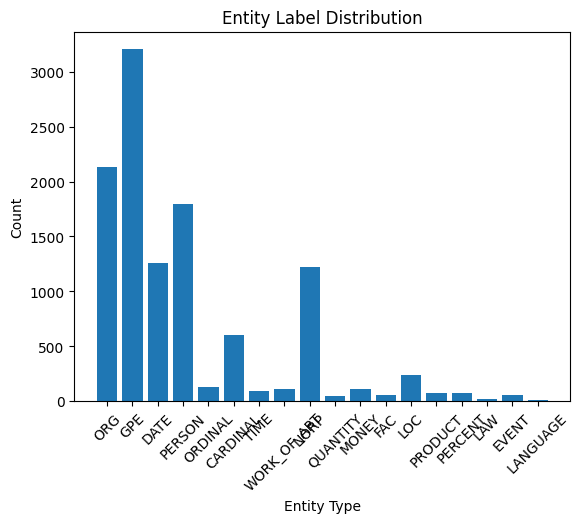

In [ ]:
article_df['entity_labels'] = article_df['entities'].apply(lambda ents: [label for _, label in ents])
all_labels = [label for labels in article_df['entity_labels'] for label in labels]
label_counts = Counter(all_labels)

# Plot
import matplotlib.pyplot as plt
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Entity Label Distribution")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


### Article Embedding

In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import spacy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained XLM-R model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)  # Ensure model is on the correct device

# Load SpaCy's language model
nlp = spacy.load("en_core_web_sm")

# Download NLTK resources
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Function to extract entities from text
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Function to map entities to actants
def map_entities_to_actants(entities):
    actants = {"subject": [], "object": [], "helper": [], "opponent": []}
    for ent, label in entities:
        if label == "PERSON":
            actants["subject"].append(ent)
        elif label in {"GPE", "ORG"}:
            actants["object"].append(ent)
        # Use sentiment to decide helper/opponent
        sentiment = sentiment_analyzer.polarity_scores(ent)['compound']
        if sentiment > 0.2:
            actants["helper"].append(ent)
        elif sentiment < -0.2:
            actants["opponent"].append(ent)
    return actants

# Function to convert actants to text format
def actants_to_text(actants):
    actants_text = []
    if actants["subject"]:
        actants_text.append(f"Subject: {', '.join(actants['subject'])}.")
    if actants["object"]:
        actants_text.append(f"Object: {', '.join(actants['object'])}.")
    if actants["helper"]:
        actants_text.append(f"Helper: {', '.join(actants['helper'])}.")
    if actants["opponent"]:
        actants_text.append(f"Opponent: {', '.join(actants['opponent'])}.")
    return " ".join(actants_text)

# Function to compute token-based embedding for an article
def compute_token_based_embedding(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length").to(device)

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Token embeddings (last hidden state)
    token_embeddings = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

    # Apply mean pooling to aggregate token embeddings
    attention_mask = inputs['attention_mask']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
    token_based_embedding = sum_embeddings / sum_mask  # Mean pooling

    # Move back to CPU and convert to NumPy
    return token_based_embedding.squeeze().cpu().numpy()

# Function to process articles
def process_articles_with_token_embeddings(article_df):
    # Extract entities and map them to actants
    article_df['entities'] = article_df['text'].apply(extract_entities)
    article_df['actants'] = article_df['entities'].apply(map_entities_to_actants)

    # Convert actants to text
    article_df['actants_text'] = article_df['actants'].apply(actants_to_text)

    # Compute token-based embeddings for article text and actant text
    article_df['token_based_embedding'] = article_df['text'].apply(compute_token_based_embedding)
    article_df['actants_embedding'] = article_df['actants_text'].apply(compute_token_based_embedding)

    # Combine text and actant embeddings
    article_df['combined_embedding'] = article_df.apply(
        lambda row: np.hstack([row['token_based_embedding'], row['actants_embedding']]),
        axis=1
    )

    return article_df

# Assuming train_articles and dev_articles DataFrames are already loaded
processed_train_df = process_articles_with_token_embeddings(train_articles)
processed_dev_df = process_articles_with_token_embeddings(dev_articles)


Using device: cuda


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Save processed DataFrames
processed_train_df.to_csv('/content/drive/MyDrive/NLP_Proj/embedded_article/processed_train_articles.csv', index=False)
processed_dev_df.to_csv('/content/drive/MyDrive/NLP_Proj/embedded_article/processed_dev_articles.csv', index=False)

# Print a sample of the processed data
processed_train_df.head()
#print(processed_dev_df.head())

,article_id,text,cc_sentiment_scores,urw_sentiment_scores,level2_sentiment_scores,sentiment_scores,entities,actants,actants_text,token_based_embedding,actants_embedding,combined_embedding
0,4,A Tesla Owner Just Exposed A Sick Secret About...,"[0.0, 0.0, -0.4854, -0.977, 0.0, 0.0, -0.25, 0...","[-0.9793, -0.7964, 0.0, 0.0, 0.0, -0.25, -0.39...","[-0.9793, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, -0.4854, -0.977, 0.0, 0.0, -0.25, 0...","[(Tesla, ORG), (Tesla, ORG), (An Inconvenient ...","{'subject': ['Al Gore', 'Teslas', 'Brad Temple...","Subject: Al Gore, Teslas, Brad Templeton, Temp...","[-0.0220115, -0.0074324175, 0.014859043, 0.003...","[-0.0022261546, 0.055587865, 0.026547622, 0.00...","[-0.0220115, -0.0074324175, 0.014859043, 0.003..."
1,6,ESG in action: Unity Foods partners with The G...,"[0.0, 0.0, 0.4939, -0.8977, 0.0, 0.0, 0.296, 0...","[0.7254, -0.4215, 0.0, 0.0, 0.0, 0.296, 0.0, 0...","[0.7254, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2732,...","[0.0, 0.0, 0.4939, -0.8977, 0.0, 0.0, 0.296, 0...","[(ESG, ORG), (Unity Foods, ORG), (The Green Ar...","{'subject': ['jerry cans', 'Habib Elahi'], 'ob...","Subject: jerry cans, Habib Elahi. Object: ESG,...","[-0.014961489, -0.011857742, -0.0007843474, -0...","[0.023054093, 0.058462076, 0.013864914, 0.0200...","[-0.014961489, -0.011857742, -0.0007843474, -0..."
2,9,Leveraging Chinese expertise to help Pakistan ...,"[0.0, 0.0, 0.3818, 0.9851, 0.6249, 0.0, 0.3818...","[0.9883, 0.0, 0.0, 0.0, 0.0, 0.3818, 0.0, 0.0,...","[0.9883, 0.0, 0.0, 0.0, 0.0, 0.9744, 0.6249, 0...","[0.0, 0.0, 0.3818, 0.9851, 0.6249, 0.0, 0.3818...","[(Chinese, NORP), (Pakistan, GPE), (Pakistan, ...","{'subject': ['Liaqat Ali Shah'], 'object': ['P...","Subject: Liaqat Ali Shah. Object: Pakistan, Pa...","[-0.013167953, 0.020093676, 0.010838951, 0.008...","[-0.012079347, 0.078377545, 0.0021905769, 0.03...","[-0.013167953, 0.020093676, 0.010838951, 0.008..."
3,12,Bill Gates Says He Is ‘The Solution’ To Climat...,"[-0.5267, 0.0, -0.8397, -0.5329, 0.0, 0.34, 0....","[0.8807, 0.0, 0.0, 0.0, 0.34, 0.6249, -0.296, ...","[0.8807, 0.0, -0.5267, 0.0, 0.0, 0.0, 0.0, 0.0...","[-0.5267, 0.0, -0.8397, -0.5329, 0.0, 0.34, 0....","[(Bill Gates, PERSON), (Jets, PERSON), (Bill G...","{'subject': ['Bill Gates', 'Jets', 'Bill Gates...","Subject: Bill Gates, Jets, Bill Gates, Bill Ga...","[-0.015397585, 0.02165544, 0.003880438, -0.007...","[-0.0127927875, 0.06957293, 0.015238972, -0.00...","[-0.015397585, 0.02165544, 0.003880438, -0.007..."
4,10,Met Office issues urgent warning as 70mph wind...,"[0.1531, 0.0, 0.7992, -0.7037, 0.0, 0.0, 0.778...","[0.8994, 0.7105, 0.0, 0.0, 0.0, 0.7783, 0.1779...","[0.8994, 0.0, 0.1531, 0.0, 0.0, 0.5499, 0.0, 0...","[0.1531, 0.0, 0.7992, -0.7037, 0.0, 0.0, 0.778...","[(Met Office, ORG), (70mph, QUANTITY), (UK, GP...","{'subject': ['Storm Jocelyn', 'Windy', 'Outloo...","Subject: Storm Jocelyn, Windy, Outlook. Object...","[0.025963038, 0.020136321, -0.014449881, 0.026...","[-0.002969738, 0.0668433, 0.020641668, 0.04076...","[0.025963038, 0.020136321, -0.014449881, 0.026..."


In [ ]:
# Processed datasets
processed_train_df = pd.read_csv('/content/drive/MyDrive/NLP_Proj/embedded_article/processed_train_articles.csv')
processed_dev_df = pd.read_csv('/content/drive/MyDrive/NLP_Proj/embedded_article/processed_dev_articles.csv')


sentiment_data_train = train_articles[['article_id', 'sentiment_scores', 'level2_sentiment_scores']]
sentiment_data_dev = dev_articles[['article_id', 'sentiment_scores', 'level2_sentiment_scores']]

# Merge sentiment data with the existing DataFrame
processed_train_df = processed_train_df.merge(
    sentiment_data_train,
    on="article_id",
    how="left"  # Use 'left' to keep all rows from processed_train_df
)

processed_dev_df = processed_dev_df.merge(
    sentiment_data_dev,
    on="article_id",
    how="left"  # Use 'left' to keep all rows from processed_dev_df
)

processed_train_df.to_csv('/content/drive/MyDrive/NLP_Proj/embedded_article/processed_train_articles.csv', index=False)
processed_dev_df.to_csv('/content/drive/MyDrive/NLP_Proj/embedded_article/processed_dev_articles.csv', index=False)


In [ ]:
processed_train_df.head()

,article_id,text,cc_sentiment_scores,urw_sentiment_scores,level2_sentiment_scores_x,sentiment_scores_x,entities,actants,actants_text,token_based_embedding,actants_embedding,combined_embedding,sentiment_scores_y,level2_sentiment_scores_y
0,4,A Tesla Owner Just Exposed A Sick Secret About...,"[0.0, 0.0, -0.4854, -0.977, 0.0, 0.0, -0.25, 0...","[-0.9793, -0.7964, 0.0, 0.0, 0.0, -0.25, -0.39...","[-0.9793, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, -0.4854, -0.977, 0.0, 0.0, -0.25, 0...","[('Tesla', 'ORG'), ('Tesla', 'ORG'), ('An Inco...","{'subject': ['Al Gore', 'Teslas', 'Brad Temple...","Subject: Al Gore, Teslas, Brad Templeton, Temp...",[-2.20114999e-02 -7.43241748e-03 1.48590431e-...,[-2.22615455e-03 5.55878654e-02 2.65476219e-...,[-0.0220115 -0.00743242 0.01485904 ... 0.01...,"[0.0, 0.0, -0.4854, -0.977, 0.0, 0.0, -0.25, 0...","[-0.9793, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
1,6,ESG in action: Unity Foods partners with The G...,"[0.0, 0.0, 0.4939, -0.8977, 0.0, 0.0, 0.296, 0...","[0.7254, -0.4215, 0.0, 0.0, 0.0, 0.296, 0.0, 0...","[0.7254, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2732,...","[0.0, 0.0, 0.4939, -0.8977, 0.0, 0.0, 0.296, 0...","[('ESG', 'ORG'), ('Unity Foods', 'ORG'), ('The...","{'subject': ['jerry cans', 'Habib Elahi'], 'ob...","Subject: jerry cans, Habib Elahi. Object: ESG,...",[-1.49614885e-02 -1.18577424e-02 -7.84347416e-...,[ 2.30540931e-02 5.84620759e-02 1.38649140e-...,[-0.01496149 -0.01185774 -0.00078435 ... 0.03...,"[0.0, 0.0, 0.4939, -0.8977, 0.0, 0.0, 0.296, 0...","[0.7254, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2732,..."
2,9,Leveraging Chinese expertise to help Pakistan ...,"[0.0, 0.0, 0.3818, 0.9851, 0.6249, 0.0, 0.3818...","[0.9883, 0.0, 0.0, 0.0, 0.0, 0.3818, 0.0, 0.0,...","[0.9883, 0.0, 0.0, 0.0, 0.0, 0.9744, 0.6249, 0...","[0.0, 0.0, 0.3818, 0.9851, 0.6249, 0.0, 0.3818...","[('Chinese', 'NORP'), ('Pakistan', 'GPE'), ('P...","{'subject': ['Liaqat Ali Shah'], 'object': ['P...","Subject: Liaqat Ali Shah. Object: Pakistan, Pa...",[-1.31679531e-02 2.00936757e-02 1.08389510e-...,[-1.20793469e-02 7.83775449e-02 2.19057687e-...,[-0.01316795 0.02009368 0.01083895 ... 0.03...,"[0.0, 0.0, 0.3818, 0.9851, 0.6249, 0.0, 0.3818...","[0.9883, 0.0, 0.0, 0.0, 0.0, 0.9744, 0.6249, 0..."
3,12,Bill Gates Says He Is ‘The Solution’ To Climat...,"[-0.5267, 0.0, -0.8397, -0.5329, 0.0, 0.34, 0....","[0.8807, 0.0, 0.0, 0.0, 0.34, 0.6249, -0.296, ...","[0.8807, 0.0, -0.5267, 0.0, 0.0, 0.0, 0.0, 0.0...","[-0.5267, 0.0, -0.8397, -0.5329, 0.0, 0.34, 0....","[('Bill Gates', 'PERSON'), ('Jets', 'PERSON'),...","{'subject': ['Bill Gates', 'Jets', 'Bill Gates...","Subject: Bill Gates, Jets, Bill Gates, Bill Ga...",[-1.53975850e-02 2.16554403e-02 3.88043793e-...,[-1.27927875e-02 6.95729330e-02 1.52389724e-...,[-0.01539758 0.02165544 0.00388044 ... 0.01...,"[-0.5267, 0.0, -0.8397, -0.5329, 0.0, 0.34, 0....","[0.8807, 0.0, -0.5267, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,10,Met Office issues urgent warning as 70mph wind...,"[0.1531, 0.0, 0.7992, -0.7037, 0.0, 0.0, 0.778...","[0.8994, 0.7105, 0.0, 0.0, 0.0, 0.7783, 0.1779...","[0.8994, 0.0, 0.1531, 0.0, 0.0, 0.5499, 0.0, 0...","[0.1531, 0.0, 0.7992, -0.7037, 0.0, 0.0, 0.778...","[('Met Office', 'ORG'), ('70mph', 'QUANTITY'),...","{'subject': ['Storm Jocelyn', 'Windy', 'Outloo...","Subject: Storm Jocelyn, Windy, Outlook. Object...",[ 2.59630382e-02 2.01363210e-02 -1.44498814e-...,[-2.96973810e-03 6.68433011e-02 2.06416678e-...,[ 0.02596304 0.02013632 -0.01444988 ... 0.10...,"[0.1531, 0.0, 0.7992, -0.7037, 0.0, 0.0, 0.778...","[0.8994, 0.0, 0.1531, 0.0, 0.0, 0.5499, 0.0, 0..."


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Label Encoding

In [ ]:
# One-hot encoding for 'narrative'
def one_hot_encode_column(df, column_name):
    unique_values = df[column_name].unique()
    mapping = {val: idx for idx, val in enumerate(unique_values)}
    df[f'{column_name}_onehot'] = df[column_name].map(mapping)
    return df, mapping

# Process level_1 and level_2 columns to create unique mappings and embeddings
def process_levels(df, level_column):
    # Get unique classes for the level
    unique_classes = df[level_column].unique()

    # Create a mapping of class to embedding
    class_to_embedding = {cls: generate_embedding(cls) for cls in unique_classes}

    # Map embeddings back to class for reversibility
    embedding_to_class = {tuple(v): k for k, v in class_to_embedding.items()}

    # Apply embedding to the DataFrame
    df[f'{level_column}_embedding'] = df[level_column].map(class_to_embedding)

    return df, class_to_embedding, embedding_to_class

# Save processed DataFrame
def save_processed_data(train_df, dev_df, train_path, dev_path):
    train_df.to_csv(train_path, index=False)
    dev_df.to_csv(dev_path, index=False)
    print(f"Train saved to {train_path}")
    print(f"Dev saved to {dev_path}")

# Process train and dev datasets
def process_annotations(train_df, dev_df):
    # One-hot encode the narrative column
    train_df, narrative_mapping = one_hot_encode_column(train_df, 'narrative')
    dev_df['narrative_onehot'] = dev_df['narrative'].map(narrative_mapping)

    # One-hot encode level_1
    train_df, level_1_mapping = one_hot_encode_column(train_df, 'level_1')
    dev_df['level_1_onehot'] = dev_df['level_1'].map(level_1_mapping)

    # One-hot encode level_2
    train_df, level_2_mapping = one_hot_encode_column(train_df, 'level_2')
    dev_df['level_2_onehot'] = dev_df['level_2'].map(level_2_mapping)


    # Combine all embeddings into a single column for training
    def combine_embeddings(row):
        return np.hstack([
            row['narrative_onehot'],
            row['level_1_onehot'],
            row['level_2_onehot']

        ])

    # Save mappings for later use
    mappings = {
        'narrative_mapping': narrative_mapping,
        'level_1_mapping': level_1_mapping,
        'level_2_mapping': level_2_mapping,
    }

    return train_df, dev_df, mappings

# Process the data
train_processed, dev_processed, mappings = process_annotations(expanded_train_annotations, expanded_dev_annotations)

# Save the processed data
save_processed_data(train_processed, dev_processed, "/content/drive/MyDrive/NLP_Proj/embedded_article/train_processed.csv", "/content/drive/MyDrive/NLP_Proj/embedded_article/dev_processed.csv")


# Display processed data
print(train_processed.head())
print(dev_processed.head())


Train saved to /content/drive/MyDrive/NLP_Proj/embedded_article/train_processed.csv
Dev saved to /content/drive/MyDrive/NLP_Proj/embedded_article/dev_processed.csv
   article_id narrative                         level_1  \
0          12        CC   Criticism of climate movement   
1         310     Other                           Other   
2         317     Other                           Other   
3          16     Other                           Other   
4         336     Other                           Other   

                                level_2  narrative_onehot  level_1_onehot  \
0   Ad hominem attacks on key activists                 0               0   
1                                 Other                 1               1   
2                                 Other                 1               1   
3                                 Other                 1               1   
4                                 Other                 1               1   

   level_2_onehot 

In [ ]:
print(mappings)

{'narrative_mapping': {'CC': 0, 'Other': 1, 'URW': 2}, 'level_1_mapping': {' Criticism of climate movement': 0, 'Other': 1, ' Questioning the measurements and science': 2, ' Speculating war outcomes': 3, ' Praise of Russia': 4, ' Russia is the Victim': 5, ' Amplifying war-related fears': 6, ' Blaming the war on others rather than the invader': 7, ' Discrediting Ukraine': 8, ' Hidden plots by secret schemes of powerful groups': 9, ' Discrediting the West, Diplomacy': 10, ' Downplaying climate change': 11, ' Overpraising the West': 12, ' Criticism of institutions and authorities': 13, ' Distrust towards Media': 14, ' Negative Consequences for the West': 15, ' Controversy about green technologies': 16, ' Climate change is beneficial': 17, ' Criticism of climate policies': 18, ' Amplifying Climate Fears': 19, ' Green policies are geopolitical instruments': 20}, 'level_2_mapping': {' Ad hominem attacks on key activists': 0, 'Other': 1, ' Scientific community is unreliable': 2, ' Other': 3, 

In [ ]:
len(train_processed)

875

### Train Test Split

In [ ]:
common_ids = processed_dev_df['article_id'][processed_dev_df['article_id'].isin(dev_processed['article_id'])]
print(f"Number of common article IDs: {len(common_ids)}")
print("Common article IDs:", len(common_ids.unique()))


Number of common article IDs: 41
Common article IDs: 41


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import ast

# Load processed datasets
processed_train_df = pd.read_csv('/content/drive/MyDrive/NLP/processed_train_articles.csv')
processed_dev_df = pd.read_csv('/content/drive/MyDrive/NLP/processed_dev_articles.csv')
train_processed = pd.read_csv('/content/drive/MyDrive/NLP/train_processed.csv')
dev_processed = pd.read_csv('/content/drive/MyDrive/NLP/dev_processed.csv')

# Merge article embeddings with annotation embeddings
merged_train = pd.merge(
    processed_train_df[['article_id', 'token_based_embedding', 'actants_embedding', 'sentiment_scores_x', 'level2_sentiment_scores_x']],
    train_processed[['article_id', 'narrative_onehot', 'level_1_onehot', 'level_2_onehot']],
    on='article_id'
)

merged_dev = pd.merge(
    processed_dev_df[['article_id', 'token_based_embedding', 'actants_embedding', 'sentiment_scores_x', 'level2_sentiment_scores_x']],
    dev_processed[['article_id', 'narrative_onehot', 'level_1_onehot', 'level_2_onehot']],
    on='article_id'
)

def string_to_array_embeds(embed_str):
    try:
        # Remove brackets and newline characters, then split into components
        embed_str = embed_str.strip("[]").replace("\n", "")
        # Convert each component to a float and return as a NumPy array
        return np.array([float(x) for x in embed_str.split() if x.strip()])
    except (ValueError, TypeError):
        # Return an empty array if parsing fails
        return np.array([])


def string_to_array(embed_str):
    try:
        # Safely evaluate the string to a Python list
        return np.array(ast.literal_eval(embed_str))
    except (ValueError, SyntaxError, TypeError):
        # Return an empty array if parsing fails
        return np.array([])


merged_train['token_based_embedding'] = merged_train['token_based_embedding'].apply(string_to_array_embeds)
merged_train['actants_embedding'] = merged_train['actants_embedding'].apply(string_to_array_embeds)
merged_train['sentiment_scores_x'] = merged_train['sentiment_scores_x'].apply(string_to_array)
merged_train['level2_sentiment_scores_x'] = merged_train['level2_sentiment_scores_x'].apply(string_to_array)

merged_dev['token_based_embedding'] = merged_dev['token_based_embedding'].apply(string_to_array_embeds)
merged_dev['actants_embedding'] = merged_dev['actants_embedding'].apply(string_to_array_embeds)
merged_dev['sentiment_scores_x'] = merged_dev['sentiment_scores_x'].apply(string_to_array)
merged_dev['level2_sentiment_scores_x'] = merged_dev['level2_sentiment_scores_x'].apply(string_to_array)

#merged_train.head()

# Pad or truncate arrays to the maximum length
def pad_or_truncate(array, target_length):
    if len(array) < target_length:
        return np.pad(array, (0, target_length - len(array)), mode='constant')
    elif len(array) > target_length:
        return array[:target_length]
    return array

# Find maximum lengths for padding
max_sentence_length = max(
    max(merged_train['token_based_embedding'].apply(len), default=0),
    max(merged_dev['token_based_embedding'].apply(len), default=0)
)

max_actants_length = max(
    max(merged_train['actants_embedding'].apply(len), default=0),
    max(merged_dev['actants_embedding'].apply(len), default=0)
)

max_senti_length = max(
    max(merged_train['sentiment_scores_x'].apply(len), default=0),
    max(merged_dev['sentiment_scores_x'].apply(len), default=0)
)

max_senti_level2_length = max(
    max(merged_train['level2_sentiment_scores_x'].apply(len), default=0),
    max(merged_dev['level2_sentiment_scores_x'].apply(len), default=0)
)

# Pad embeddings for sentence and actants
for df in [merged_train, merged_dev]:
    df['token_based_embedding'] = df['token_based_embedding'].apply(lambda x: pad_or_truncate(x, max_sentence_length))
    df['actants_embedding'] = df['actants_embedding'].apply(lambda x: pad_or_truncate(x, max_actants_length))
    df['sentiment_scores_x'] = df['sentiment_scores_x'].apply(lambda x: pad_or_truncate(x, max_senti_length))
    df['level2_sentiment_scores_x'] = df['level2_sentiment_scores_x'].apply(lambda x: pad_or_truncate(x, max_senti_level2_length))


# Perform stratified splitting for validation and test sets
validation_df, test_df = train_test_split(
    merged_dev,
    test_size=0.5,  # Split evenly between validation and test
    stratify=merged_dev['narrative_onehot'],  # Stratify by 'narrative_onehot'
    random_state=42
)

# Prepare training and validation splits
X_train = np.hstack([
    np.vstack(merged_train['token_based_embedding']),
    np.vstack(merged_train['actants_embedding']),
    np.vstack(merged_train['sentiment_scores_x'])
    #np.vstack(merged_train['level2_sentiment_scores'])
])

y_train = merged_train[['narrative_onehot', 'level_1_onehot', 'level_2_onehot']].to_dict(orient='list')

X_val = np.hstack([
    np.vstack(validation_df['token_based_embedding']),
    np.vstack(validation_df['actants_embedding']),
    np.vstack(validation_df['sentiment_scores_x'])
    #np.vstack(validation_df['level2_sentiment_scores'])
])

y_val = validation_df[['narrative_onehot', 'level_1_onehot', 'level_2_onehot']].to_dict(orient='list')

# Prepare test splits
X_test = np.hstack([
    np.vstack(test_df['token_based_embedding']),
    np.vstack(test_df['actants_embedding']),
    np.vstack(test_df['sentiment_scores_x'])
    #np.vstack(test_df['level2_sentiment_scores'])
])

y_test = test_df[['narrative_onehot', 'level_1_onehot', 'level_2_onehot']].to_dict(orient='list')

# Print train-validation-test split details
print(f"Train: X_train: {X_train.shape}, y_train: {[len(y) for y in y_train.values()]}")
print(f"Validation: X_val: {X_val.shape}, y_val: {[len(y) for y in y_val.values()]}")
print(f"Test: X_test: {X_test.shape}, y_test: {[len(y) for y in y_test.values()]}")


Train: X_train: (875, 1576), y_train: [875, 875, 875]
Validation: X_val: (57, 1576), y_val: [57, 57, 57]
Test: X_test: (57, 1576), y_test: [57, 57, 57]


In [ ]:
# Unpack target labels for training
# Reshape X_train, X_val, and X_test to remove the extra dimension
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(f"X_train shape: {X_train.shape}")  # Should be (526, 1536)
print(f"X_val shape: {X_val.shape}")      # Should be (14, 1536)
print(f"X_test shape: {X_test.shape}")    # Should be (57, 1536)

y_train_narrative = np.array(y_train['narrative_onehot'])
y_train_level_1 = np.array(y_train['level_1_onehot'])
y_train_level_2 = np.array(y_train['level_2_onehot'])

# Unpack target labels for validation
y_val_narrative = np.array(y_val['narrative_onehot'])
y_val_level_1 = np.array(y_val['level_1_onehot'])
y_val_level_2 = np.array(y_val['level_2_onehot'])

# Unpack target labels for testing
y_test_narrative = np.array(y_test['narrative_onehot'])
y_test_level_1 = np.array(y_test['level_1_onehot'])
y_test_level_2 = np.array(y_test['level_2_onehot'])

# Print the shapes to verify
print(f"y_train_narrative shape: {y_train_narrative.shape}")
print(f"y_train_level_1 shape: {y_train_level_1.shape}")
print(f"y_train_level_2 shape: {y_train_level_2.shape}")

print(f"y_val_narrative shape: {y_val_narrative.shape}")
print(f"y_val_level_1 shape: {y_val_level_1.shape}")
print(f"y_val_level_2 shape: {y_val_level_2.shape}")

print(f"y_test_narrative shape: {y_test_narrative.shape}")
print(f"y_test_level_1 shape: {y_test_level_1.shape}")
print(f"y_test_level_2 shape: {y_test_level_2.shape}")


X_train shape: (875, 1576)
X_val shape: (57, 1576)
X_test shape: (57, 1576)
y_train_narrative shape: (875,)
y_train_level_1 shape: (875,)
y_train_level_2 shape: (875,)
y_val_narrative shape: (57,)
y_val_level_1 shape: (57,)
y_val_level_2 shape: (57,)
y_test_narrative shape: (57,)
y_test_level_1 shape: (57,)
y_test_level_2 shape: (57,)


### Class Imbalance

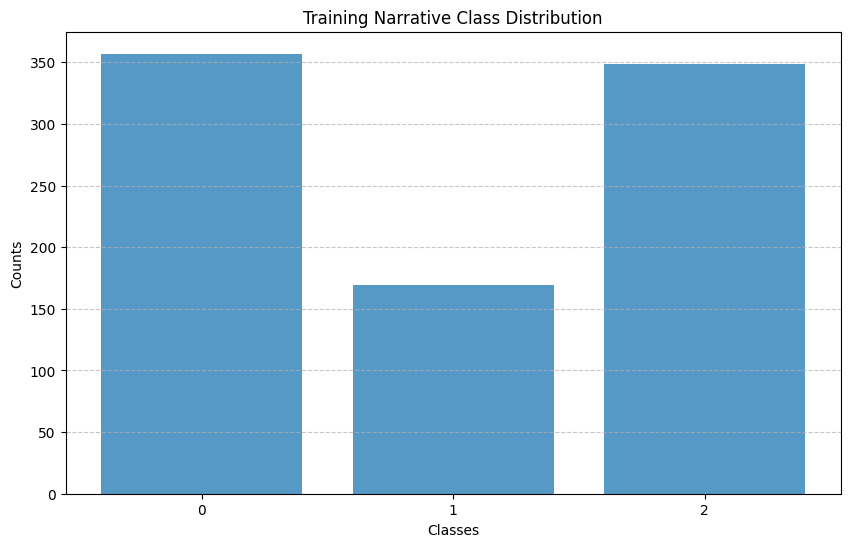

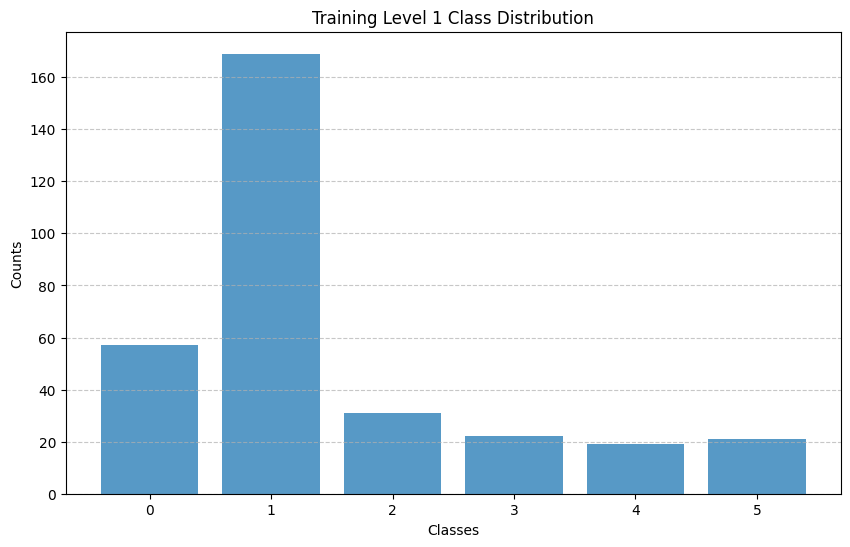

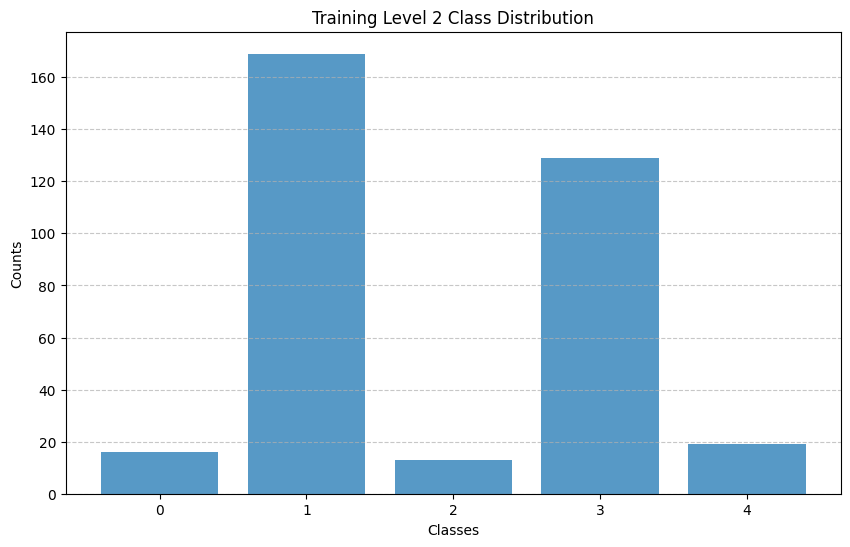

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting function
def plot_class_distribution(title, class_counts):
    labels = list(class_counts.keys())
    values = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, alpha=0.75)
    plt.title(f"{title} Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Counts")
    plt.xticks(labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Visualize distributions
plot_class_distribution("Training Narrative", train_class_counts_narrative)
plot_class_distribution("Training Level 1", train_class_counts_level_1)
plot_class_distribution("Training Level 2", train_class_counts_level_2)


### Transformer Based Attention

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Function to replace NaN with -1 in the labels
def replace_nan_with_negative_one(array):
    return np.where(np.isnan(array), -1, array)

# Replace NaN values in all levels with -1
y_train_level2 = replace_nan_with_negative_one(np.array(y_train_level_2))
y_val_level2 = replace_nan_with_negative_one(np.array(y_val_level_2))
y_test_level2 = replace_nan_with_negative_one(np.array(y_test_level_2))

# Narrative Level
y_train_narrative_onehot = to_categorical(y_train_narrative, num_classes=len(np.unique(y_train_narrative)))
y_val_narrative_onehot = to_categorical(y_val_narrative, num_classes=len(np.unique(y_train_narrative)))
y_test_narrative_onehot = to_categorical(y_test_narrative, num_classes=len(np.unique(y_train_narrative)))

narrative_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_narrative), y=y_train_narrative)
narrative_class_weights = dict(enumerate(narrative_class_weights))

# Level 1
y_train_level1_onehot = to_categorical(y_train_level_1, num_classes=len(np.unique(y_train_level_1)))
y_val_level1_onehot = to_categorical(y_val_level_1, num_classes=len(np.unique(y_train_level_1)))
y_test_level1_onehot = to_categorical(y_test_level_1, num_classes=len(np.unique(y_train_level_1)))

level1_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_level_1), y=y_train_level_1)
level1_class_weights = dict(enumerate(level1_class_weights))

# Level 2 (including -1 as a separate class)
y_train_level2_onehot = to_categorical(y_train_level2, num_classes=len(np.unique(y_train_level2)))
y_val_level2_onehot = to_categorical(y_val_level2, num_classes=len(np.unique(y_train_level2)))
y_test_level2_onehot = to_categorical(y_test_level2, num_classes=len(np.unique(y_train_level2)))

level2_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_level_2), y=y_train_level_2)
level2_class_weights = dict(enumerate(level2_class_weights))

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train_narrative_onehot shape: {y_train_narrative_onehot.shape}")
print(f"y_val_narrative_onehot shape: {y_val_narrative_onehot.shape}")
print(f"y_test_narrative_onehot shape: {y_test_narrative_onehot.shape}")

print(f"y_train_level1_onehot shape: {y_train_level1_onehot.shape}")
print(f"y_val_level1_onehot shape: {y_val_level1_onehot.shape}")
print(f"y_test_level1_onehot shape: {y_test_level1_onehot.shape}")

print(f"y_train_level2_onehot shape: {y_train_level2_onehot.shape}")
print(f"y_val_level2_onehot shape: {y_val_level2_onehot.shape}")
print(f"y_test_level2_onehot shape: {y_test_level2_onehot.shape}")

# Print class weights
print("\nNarrative Class Weights:", narrative_class_weights)
print("Level 1 Class Weights:", level1_class_weights)
print("Level 2 Class Weights:", level2_class_weights)


X_train shape: (875, 1576)
y_train_narrative_onehot shape: (875, 3)
y_val_narrative_onehot shape: (57, 3)
y_test_narrative_onehot shape: (57, 3)
y_train_level1_onehot shape: (875, 21)
y_val_level1_onehot shape: (57, 21)
y_test_level1_onehot shape: (57, 21)
y_train_level2_onehot shape: (875, 70)
y_val_level2_onehot shape: (57, 70)
y_test_level2_onehot shape: (57, 70)

Narrative Class Weights: {0: 0.8169934640522876, 1: 1.7258382642998027, 2: 0.8357211079274116}
Level 1 Class Weights: {0: 0.7309941520467836, 1: 0.2465483234714004, 2: 1.3440860215053763, 3: 1.893939393939394, 4: 2.192982456140351, 5: 1.9841269841269842, 6: 0.6944444444444444, 7: 1.1904761904761905, 8: 0.7716049382716049, 9: 0.6944444444444444, 10: 0.49019607843137253, 11: 1.4367816091954022, 12: 3.787878787878788, 13: 0.49603174603174605, 14: 3.2051282051282053, 15: 2.6041666666666665, 16: 1.2254901960784315, 17: 8.333333333333334, 18: 0.7183908045977011, 19: 5.9523809523809526, 20: 8.333333333333334}
Level 2 Class Weight

In [ ]:
from tensorflow.keras.utils import to_categorical

# Ensure y_train_narrative is correctly sourced and matches X_train
y_train_narrative = np.array(y_train_narrative)  # Ensure it's a NumPy array
y_train_narrative_onehot = to_categorical(y_train_narrative, num_classes=len(np.unique(y_train_narrative)))

# Repeat for validation and test sets
y_val_narrative = np.array(y_val_narrative)  # Ensure it's a NumPy array
y_val_narrative_onehot = to_categorical(y_val_narrative, num_classes=len(np.unique(y_train_narrative)))

y_test_narrative = np.array(y_test_narrative)  # Ensure it's a NumPy array
y_test_narrative_onehot = to_categorical(y_test_narrative, num_classes=len(np.unique(y_train_narrative)))

# Check shapes again
print(f"X_train shape: {X_train.shape}")
print(f"y_train_narrative_onehot shape: {y_train_narrative_onehot.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val_narrative_onehot shape: {y_val_narrative_onehot.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_narrative_onehot shape: {y_test_narrative_onehot.shape}")


from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for the narrative labels
unique_classes = np.unique(y_train_narrative)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_narrative)
narrative_class_weights = dict(enumerate(class_weights))

print("Narrative Class Weights:", narrative_class_weights)


X_train shape: (875, 1576)
y_train_narrative_onehot shape: (875, 3)
X_val shape: (57, 1576)
y_val_narrative_onehot shape: (57, 3)
X_test shape: (57, 1576)
y_test_narrative_onehot shape: (57, 3)
Narrative Class Weights: {0: 0.8169934640522876, 1: 1.7258382642998027, 2: 0.8357211079274116}


In [ ]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    MultiHeadAttention,
    LayerNormalization,
    GlobalAveragePooling1D,
    Flatten,
    Embedding,
    Add,
)
from tensorflow.keras.models import Model


class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, input_dim, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.embedding = Embedding(input_dim=input_dim, output_dim=embed_dim)

    def call(self, inputs):
        # Create a range for positional indices
        positions = tf.range(self.input_dim, dtype=tf.int32)
        positional_encoding = self.embedding(positions)  # Positional embeddings
        positional_encoding = tf.expand_dims(positional_encoding, axis=0)  # Add batch dimension
        positional_encoding = tf.repeat(positional_encoding, repeats=tf.shape(inputs)[0], axis=0)  # Repeat for batch size
        return positional_encoding


def create_transformer_based_model(input_shape, num_classes, num_transformer_layers=2):
    inputs = Input(shape=(input_shape,))  # Input feature vector (e.g., embeddings)

    # Project input to a lower dimension (matching feedforward dimensions)
    projected_inputs = Dense(
        256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(inputs)  # Project input features to 256 dimensions
    reshaped_inputs = tf.keras.layers.Reshape((1, 256))(projected_inputs)  # Reshape for Multi-Head Attention

    # Positional Encoding Layer
    positional_encoding_layer = PositionalEncoding(input_dim=input_shape, embed_dim=256)
    positional_encoding = positional_encoding_layer(reshaped_inputs)

    # Add Positional Encoding
    reshaped_inputs_with_positional = Add()([reshaped_inputs, positional_encoding])  # Add positional information

    # Stacked Transformer Layers
    transformer_output = reshaped_inputs_with_positional
    for _ in range(num_transformer_layers):
        attention_output = MultiHeadAttention(num_heads=8, key_dim=32)(
            transformer_output, transformer_output
        )
        attention_output = LayerNormalization(epsilon=1e-6)(
            attention_output + transformer_output
        )  # Residual connection

        # Feedforward Network with L2 Regularization and Dropout
        ff_output = Dense(
            256,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
        )(attention_output)
        ff_output = Dropout(0.4)(ff_output)  # Dropout Regularization
        transformer_output = LayerNormalization(epsilon=1e-6)(
            ff_output + attention_output
        )  # Residual connection
        # Batch Normalization after Dense layers
        ff_output = Dense(
            256,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
        )(attention_output)
        ff_output = BatchNormalization()(ff_output)  # Add Batch Normalization
        ff_output = Dropout(0.4)(ff_output)

    # Global Pooling Layer (applied after all transformer layers)
    pooled_output = GlobalAveragePooling1D()(transformer_output)  # Collapse sequence dimension

    # Dropout for Regularization
    pooled_output = Dropout(0.5)(pooled_output)

    # Output Layer for Classification with Regularization
    outputs = Dense(
        num_classes,
        activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        )(pooled_output)

    # Define Model
    model = Model(inputs, outputs)
    return model


# Apply SMOTE for Oversampling Minority Classes
def apply_smote(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled


# Oversample the training data using SMOTE
X_train_resampled, y_train_narrative_resampled = apply_smote(X_train, y_train_narrative)

# One-hot encode the resampled target labels
y_train_narrative_onehot_resampled = tf.keras.utils.to_categorical(
    y_train_narrative_resampled, num_classes=len(np.unique(y_train_narrative))
)

# Calculate class weights (optional, may not be needed after SMOTE)
class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train_narrative_resampled), y=y_train_narrative_resampled
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,  # Higher initial learning rate
    decay_steps=500,             # Faster decay
    decay_rate=0.9
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Model Parameters
input_shape = X_train.shape[1]  # Number of features in the input
num_classes_narrative = len(np.unique(y_train_narrative))  # Number of narrative classes

# Create the model with regularization
narrative_model = create_transformer_based_model(input_shape=input_shape, num_classes=num_classes_narrative)

# Compile the model
narrative_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model with Early Stopping
history = narrative_model.fit(
    X_train_resampled,
    y_train_narrative_onehot_resampled,
    validation_data=(X_val, y_val_narrative_onehot),
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = narrative_model.evaluate(X_test, y_test_narrative_onehot, verbose=1)

# Predict on the test set
y_test_preds = narrative_model.predict(X_test, batch_size=64)
y_test_pred_classes = np.argmax(y_test_preds, axis=1)  # Convert probabilities to class labels

# True class labels
y_test_true_classes = np.argmax(y_test_narrative_onehot, axis=1)

# Calculate metrics
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)
f1_macro = f1_score(y_test_true_classes, y_test_pred_classes, average="macro")
f1_weighted = f1_score(y_test_true_classes, y_test_pred_classes, average="weighted")

# Print results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 55s 976ms/step - accuracy: 0.3970 - loss: 9.6114 - val_accuracy: 0.8947 - val_loss: 5.0048
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 534ms/step - accuracy: 0.5619 - loss: 4.8749 - val_accuracy: 0.8421 - val_loss: 3.1909
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 565ms/step - accuracy: 0.6305 - loss: 3.4137 - val_accuracy: 0.9474 - val_loss: 2.2854
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 603ms/step - accuracy: 0.7397 - loss: 2.4702 - val_accuracy: 0.9298 - val_loss: 1.7624
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 597ms/step - accuracy: 0.7584 - loss: 1.9929 - val_accuracy: 0.9298 - val_loss: 1.4875
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 579ms/step - accuracy: 0.7399 - loss: 1.7608 - val_accuracy: 0.8772 - val_loss: 1.4211
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 586ms/step - accuracy: 0.7838 - loss: 1.4822 - val_accuracy: 0.8772 - val_loss: 1.2139
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 588ms/step - accuracy: 0.7972 - loss: 1.2524 - val_accu

In [ ]:
# Get predictions for the first 5 test samples
num_samples = 10
sample_inputs = X_test[:num_samples]
sample_preds = narrative_model.predict(sample_inputs)
sample_pred_classes = np.argmax(sample_preds, axis=1)
sample_true_classes = np.argmax(y_test_narrative_onehot[:num_samples], axis=1)

# Print results for each sample
for i in range(num_samples):
    print(f"Sample Index: {i}")
    print(f"Predicted Class: {sample_pred_classes[i]}")
    print(f"True Class: {sample_true_classes[i]}")
    print("---")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sample Index: 0
Predicted Class: 2
True Class: 1
---
Sample Index: 1
Predicted Class: 1
True Class: 0
---
Sample Index: 2
Predicted Class: 0
True Class: 0
---
Sample Index: 3
Predicted Class: 2
True Class: 2
---
Sample Index: 4
Predicted Class: 0
True Class: 0
---
Sample Index: 5
Predicted Class: 0
True Class: 0
---
Sample Index: 6
Predicted Class: 2
True Class: 2
---
Sample Index: 7
Predicted Class: 2
True Class: 2
---
Sample Index: 8
Predicted Class: 0
True Class: 0
---
Sample Index: 9
Predicted Class: 0
True Class: 0
---


### Combined

In [ ]:
from tensorflow.keras.layers import (
    Embedding, Concatenate, Input, Dense, Dropout, BatchNormalization, Reshape,
    MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
import tensorflow as tf

def create_regularized_hierarchical_model(
    input_shape, num_narrative_classes, num_level1_classes, num_level2_classes,
    num_transformer_layers=3, num_heads=8,  # Reduce transformer layers and heads
    hidden_units=128, shared_hidden_units=256,  # Reduce hidden units
    narrative_embedding_dim=50, level1_embedding_dim=16,  # Reduce embedding dimensions
    attention_dropout_rate=0.3, dropout_rate=0.5, l2_lambda=0.02  # Stronger regularization
):
    # Inputs
    features_input = Input(shape=(input_shape,), name="features_input")
    narrative_input = Input(shape=(1,), name="narrative_input")
    level1_input = Input(shape=(1,), name="level1_input")

    # Narrative Embedding
    narrative_embedding = Embedding(
        input_dim=num_narrative_classes,
        output_dim=narrative_embedding_dim,
        embeddings_initializer="he_normal",
        input_length=1
    )(narrative_input)
    narrative_embedding = Reshape((narrative_embedding_dim,))(narrative_embedding)

    # Level 1 Embedding
    level1_embedding = Embedding(
        input_dim=num_level1_classes,
        output_dim=level1_embedding_dim,
        embeddings_initializer="he_normal",
        input_length=1
    )(level1_input)
    level1_embedding = Reshape((level1_embedding_dim,))(level1_embedding)

    # **Narrative Prediction**
    narrative_features = Dense(
        hidden_units, activation="relu", kernel_initializer="he_normal",
        kernel_regularizer=l2(l2_lambda)
    )(features_input)
    narrative_features = BatchNormalization()(narrative_features)
    narrative_features = Dropout(dropout_rate)(narrative_features)
    narrative_output = Dense(
        num_narrative_classes, activation="softmax", kernel_regularizer=l2(l2_lambda),
        name="narrative_output"
    )(narrative_features)

    # **Level 1 Prediction**
    level1_features = Concatenate()([features_input, narrative_embedding])
    level1_shared_features = Dense(
        shared_hidden_units, activation="relu", kernel_initializer="he_normal",
        kernel_regularizer=l2(l2_lambda)
    )(level1_features)
    level1_shared_features = BatchNormalization()(level1_shared_features)
    level1_shared_features = Dropout(dropout_rate)(level1_shared_features)
    level1_shared_features = Reshape((1, shared_hidden_units))(level1_shared_features)

    # Transformer for Level 1
    transformer_output_level1 = level1_shared_features
    for _ in range(num_transformer_layers):
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=shared_hidden_units // num_heads,
            dropout=attention_dropout_rate
        )(transformer_output_level1, transformer_output_level1)
        attention_output = LayerNormalization(epsilon=1e-6)(Add()([attention_output, transformer_output_level1]))

        ff_output = Dense(
            shared_hidden_units, activation="relu", kernel_initializer="he_normal",
            kernel_regularizer=l2(l2_lambda)
        )(attention_output)
        ff_output = Dropout(dropout_rate)(ff_output)
        transformer_output_level1 = LayerNormalization(epsilon=1e-6)(Add()([ff_output, attention_output]))

    pooled_level1_output = GlobalAveragePooling1D()(transformer_output_level1)
    pooled_level1_output = Dropout(dropout_rate)(pooled_level1_output)
    level1_output = Dense(
        num_level1_classes, activation="softmax", kernel_regularizer=l2(l2_lambda),
        name="level1_output"
    )(pooled_level1_output)

    # **Level 2 Prediction**
    level2_features = Concatenate()([features_input, narrative_embedding, level1_embedding])
    level2_shared_features = Dense(
        shared_hidden_units, activation="relu", kernel_initializer="he_normal",
        kernel_regularizer=l2(l2_lambda)
    )(level2_features)
    level2_shared_features = BatchNormalization()(level2_shared_features)
    level2_shared_features = Dropout(dropout_rate)(level2_shared_features)
    level2_shared_features = Reshape((1, shared_hidden_units))(level2_shared_features)

    # Transformer for Level 2
    transformer_output_level2 = level2_shared_features
    for _ in range(num_transformer_layers):
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=shared_hidden_units // num_heads,
            dropout=attention_dropout_rate
        )(transformer_output_level2, transformer_output_level2)
        attention_output = LayerNormalization(epsilon=1e-6)(Add()([attention_output, transformer_output_level2]))

        ff_output = Dense(
            shared_hidden_units, activation="relu", kernel_initializer="he_normal",
            kernel_regularizer=l2(l2_lambda)
        )(attention_output)
        ff_output = Dropout(dropout_rate)(ff_output)
        transformer_output_level2 = LayerNormalization(epsilon=1e-6)(Add()([ff_output, attention_output]))

    pooled_level2_output = GlobalAveragePooling1D()(transformer_output_level2)
    pooled_level2_output = Dropout(dropout_rate)(pooled_level2_output)
    level2_output = Dense(
        num_level2_classes, activation="softmax", kernel_regularizer=l2(l2_lambda),
        name="level2_output"
    )(pooled_level2_output)

    # Define the Model
    model = Model(
        inputs=[features_input, narrative_input, level1_input],
        outputs=[narrative_output, level1_output, level2_output]
    )
    return model

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# **Learning Rate Scheduler**
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)

# Compile the Model
model = create_improved_hierarchical_model(
    input_shape=X_train.shape[1],
    num_narrative_classes=len(np.unique(y_train_narrative)),
    num_level1_classes=len(np.unique(y_train_level_1)),
    num_level2_classes=len(np.unique(y_train_level_2))
)
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=["categorical_crossentropy", "categorical_crossentropy", "categorical_crossentropy"],
    metrics=["accuracy", "accuracy", "accuracy"]
)

# Train the Model
history = model.fit(
    X_train_combined,
    [y_train_narrative_onehot, y_train_level1_onehot, y_train_level2_onehot],
    validation_data=(X_val_combined, [y_val_narrative_onehot, y_val_level1_onehot, y_val_level2_onehot]),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the Model
test_loss, narrative_loss, level1_loss, level2_loss, narrative_acc, level1_acc, level2_acc = model.evaluate(
    X_test_combined, [y_test_narrative_onehot, y_test_level1_onehot, y_test_level2_onehot]
)

print(f"Test Accuracy (Narrative): {narrative_acc:.4f}")
print(f"Test Accuracy (Level 1): {level1_acc:.4f}")
print(f"Test Accuracy (Level 2): {level2_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 12, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - level1_output_accuracy: 0.2246 - level1_output_loss: 3.2315 - level2_output_accuracy: 0.1961 - level2_output_loss: 4.2650 - loss: 150.2729 - narrative_output_accuracy: 0.6428 - narrative_output_loss: 0.8653 - val_level1_output_accuracy: 0.2456 - val_level1_output_loss: 2.6360 - val_level2_output_accuracy: 0.1930 - val_level2_output_loss: 3.4905 - val_loss: 123.4929 - val_narrative_output_accuracy: 0.4211 - val_narrative_output_loss: 0.9873
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - level1_output_accuracy: 0.3050 - level1_output_loss: 2.3596 - level2_output_accuracy: 0.2829 - level2_output_loss: 3.1536 - loss: 114.3942 - narrative_output_accuracy: 0.8804 - narrative_output_loss: 0.2941 - val_level1_output_accuracy: 0.2105 - val_level1_output_loss: 2.3130 - val_level2_output_accuracy: 0.2456 - val_level2_output_loss: 3.3595 - val_loss: 92.8550 - val_narrative_output_accuracy: 0.4211 - val_narrative_output_loss: 0.8404
Epoch 3/50
28/28 

In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
import numpy as np

# Predict on the test set
y_test_preds_narrative, y_test_preds_level1, y_test_preds_level2 = model.predict(X_test_combined, batch_size=64)

# Convert predictions to class labels
y_test_pred_classes_narrative = np.argmax(y_test_preds_narrative, axis=1)
y_test_pred_classes_level1 = np.argmax(y_test_preds_level1, axis=1)
y_test_pred_classes_level2 = np.argmax(y_test_preds_level2, axis=1)

# Convert one-hot encoded test labels to class labels
y_test_true_classes_narrative = np.argmax(y_test_narrative_onehot, axis=1)
y_test_true_classes_level1 = np.argmax(y_test_level1_onehot, axis=1)
y_test_true_classes_level2 = np.argmax(y_test_level2_onehot, axis=1)

# Calculate F1-Scores and Accuracy for each level
f1_macro_narrative = f1_score(y_test_true_classes_narrative, y_test_pred_classes_narrative, average="macro")
f1_weighted_narrative = f1_score(y_test_true_classes_narrative, y_test_pred_classes_narrative, average="weighted")

f1_macro_level1 = f1_score(y_test_true_classes_level1, y_test_pred_classes_level1, average="macro")
f1_weighted_level1 = f1_score(y_test_true_classes_level1, y_test_pred_classes_level1, average="weighted")

f1_macro_level2 = f1_score(y_test_true_classes_level2, y_test_pred_classes_level2, average="macro")
f1_weighted_level2 = f1_score(y_test_true_classes_level2, y_test_pred_classes_level2, average="weighted")

# Display F1-scores
print(f"F1-Score (Macro) - Narrative: {f1_macro_narrative:.4f}")
print(f"F1-Score (Weighted) - Narrative: {f1_weighted_narrative:.4f}")
print(f"F1-Score (Macro) - Level 1: {f1_macro_level1:.4f}")
print(f"F1-Score (Weighted) - Level 1: {f1_weighted_level1:.4f}")
print(f"F1-Score (Macro) - Level 2: {f1_macro_level2:.4f}")
print(f"F1-Score (Weighted) - Level 2: {f1_weighted_level2:.4f}")

# Display sample hierarchical predictions
sample_indices = np.random.choice(len(y_test_true_classes_narrative), size=10, replace=False)

print("\nSample Hierarchical Predictions:")
for i in sample_indices:
    print(f"Sample {i+1}:")
    print(f"  True Narrative: {y_test_true_classes_narrative[i]}, Predicted Narrative: {y_test_pred_classes_narrative[i]}")
    print(f"  True Level 1: {y_test_true_classes_level1[i]}, Predicted Level 1: {y_test_pred_classes_level1[i]}")
    print(f"  True Level 2: {y_test_true_classes_level2[i]}, Predicted Level 2: {y_test_pred_classes_level2[i]}")
    print("-" * 50)


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (57, 12, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
F1-Score (Macro) - Narrative: 0.7889
F1-Score (Weighted) - Narrative: 0.8727
F1-Score (Macro) - Level 1: 0.0538
F1-Score (Weighted) - Level 1: 0.1026
F1-Score (Macro) - Level 2: 0.0849
F1-Score (Weighted) - Level 2: 0.2002

Sample Hierarchical Predictions:
Sample 13:
  True Narrative: 0, Predicted Narrative: 0
  True Level 1: 13, Predicted Level 1: 13
  True Level 2: 35, Predicted Level 2: 27
--------------------------------------------------
Sample 39:
  True Narrative: 2, Predicted Narrative: 2
  True Level 1: 10, Predicted Level 1: 1
  True Level 2: 41, Predicted Level 2: 3
--------------------------------------------------
Sample 11:
  True Narrative: 2, Predicted Narrative: 2
  True Level 1: 10, Predicted Level 1: 1
  True Level 2: 57, Predicted Level 2: 3
--------------------------------------------------
Sample 18:
  True Narrative: 2, Predicted Narrative: 2
  True Level 1: 7, Predicted Level 1: 1
  True Level 2: 9, Predicted Level 2: 3
------

### Parameter tuning (other architectures of the model that was tried)

In [ ]:
from tensorflow.keras.layers import Embedding, Concatenate, Input, Dense, Dropout, BatchNormalization, Reshape, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model

def create_shared_transformer_model_with_level1(
    input_shape, num_narrative_classes, num_level1_classes, num_level2_classes,
    num_transformer_layers=2, num_heads=8,
    hidden_units=128, shared_hidden_units=256,
    narrative_embedding_dim=50, level1_embedding_dim=16,  # Embedding dimensions
    dropout_rate=0.5, l2_lambda=0.01
):
    # Inputs
    features_input = Input(shape=(input_shape,), name="features_input")  # X_train features
    narrative_input = Input(shape=(1,), name="narrative_input")  # Narrative (categorical)
    level1_input = Input(shape=(1,), name="level1_input")  # Level 1 Ground Truth (categorical)

    # Narrative Embedding
    narrative_embedding = Embedding(
        input_dim=num_narrative_classes,
        output_dim=narrative_embedding_dim,
        embeddings_initializer="he_normal",
        input_length=1
    )(narrative_input)
    narrative_embedding = Reshape((narrative_embedding_dim,))(narrative_embedding)

    # Level 1 Embedding
    level1_embedding = Embedding(
        input_dim=num_level1_classes,
        output_dim=level1_embedding_dim,
        embeddings_initializer="he_normal",
        input_length=1
    )(level1_input)
    level1_embedding = Reshape((level1_embedding_dim,))(level1_embedding)

    # Input for Level 1: X_train + narrative
    level1_features = Concatenate()([features_input, narrative_embedding])

    # Shared feature extraction for Level 1
    level1_shared_features = Dense(
        shared_hidden_units, activation="relu", kernel_initializer="he_normal",
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
    )(level1_features)
    level1_shared_features = BatchNormalization()(level1_shared_features)
    level1_shared_features = Dropout(dropout_rate)(level1_shared_features)
    level1_shared_features = Reshape((1, shared_hidden_units))(level1_shared_features)

    # Transformer layers for Level 1
    transformer_output_level1 = level1_shared_features
    for _ in range(num_transformer_layers):
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=shared_hidden_units // num_heads)(
            transformer_output_level1, transformer_output_level1
        )
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output + transformer_output_level1)
        ff_output = Dense(
            shared_hidden_units, activation="relu", kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
        )(attention_output)
        ff_output = Dropout(dropout_rate)(ff_output)
        transformer_output_level1 = LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

    # Pooling for Level 1
    pooled_level1_output = GlobalAveragePooling1D()(transformer_output_level1)
    pooled_level1_output = Dropout(dropout_rate)(pooled_level1_output)

    # Output for Level 1
    level1_output = Dense(
        num_level1_classes, activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
        name="level1_output"
    )(pooled_level1_output)

    # Input for Level 2: X_train + narrative + Level 1 ground truth
    level2_features = Concatenate()([features_input, narrative_embedding, level1_embedding])

    # Shared feature extraction for Level 2
    level2_shared_features = Dense(
        shared_hidden_units, activation="relu", kernel_initializer="he_normal",
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
    )(level2_features)
    level2_shared_features = BatchNormalization()(level2_shared_features)
    level2_shared_features = Dropout(dropout_rate)(level2_shared_features)
    level2_shared_features = Reshape((1, shared_hidden_units))(level2_shared_features)

    # Transformer layers for Level 2
    transformer_output_level2 = level2_shared_features
    for _ in range(num_transformer_layers):
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=shared_hidden_units // num_heads)(
            transformer_output_level2, transformer_output_level2
        )
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output + transformer_output_level2)
        ff_output = Dense(
            shared_hidden_units, activation="relu", kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
        )(attention_output)
        ff_output = Dropout(dropout_rate)(ff_output)
        transformer_output_level2 = LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

    # Pooling for Level 2
    pooled_level2_output = GlobalAveragePooling1D()(transformer_output_level2)
    pooled_level2_output = Dropout(dropout_rate)(pooled_level2_output)

    # Output for Level 2
    level2_output = Dense(
        num_level2_classes, activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
        name="level2_output"
    )(pooled_level2_output)

    # Define the model
    model = Model(inputs=[features_input, narrative_input, level1_input], outputs=[level1_output, level2_output])
    return model


# Define the number of classes
num_narrative_classes = len(np.unique(y_train_narrative))
num_level1_classes = len(np.unique(y_train_level_1))
num_level2_classes = len(np.unique(y_train_level_2))

# Create the model
model = create_shared_transformer_model_with_level1(
    input_shape=X_train.shape[1],
    num_narrative_classes=num_narrative_classes,
    num_level1_classes=num_level1_classes,
    num_level2_classes=num_level2_classes,
    num_transformer_layers=4,  # Increase number of transformer layers
    num_heads=16,             # More attention heads
    hidden_units=256,         # Increase hidden layer size
    shared_hidden_units=512,  # Larger shared feature dimension
    narrative_embedding_dim=50,  # Dimension of narrative embeddings
    level1_embedding_dim=16,  # Dimension of Level 1 embeddings
    dropout_rate=0.3,         # Reduce dropout to avoid excessive regularization
    l2_lambda=0.01
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=["categorical_crossentropy", "categorical_crossentropy"],
    metrics=["accuracy", "accuracy"]
)

# Prepare the training data
X_train_combined = [X_train, y_train_narrative.reshape(-1, 1), y_train_level_1.reshape(-1, 1)]  # Level 1 uses X_train + narrative
X_val_combined = [X_val, y_val_narrative.reshape(-1, 1), y_val_level_1.reshape(-1, 1)]         # Validation data

# Train the model
history = model.fit(
    X_train_combined,
    [y_train_level1_onehot, y_train_level2_onehot],  # Outputs for Level 1 and Level 2
    validation_data=(X_val_combined, [y_val_level1_onehot, y_val_level2_onehot]),
    epochs=30,
    batch_size=32,
    verbose=1
)

# Evaluate on the test set
X_test_combined = [X_test, y_test_narrative.reshape(-1, 1), y_test_level_1.reshape(-1, 1)]  # Test data includes X_test + narrative + Level 1 ground truth
test_loss, level1_loss, level2_loss, level1_acc, level2_acc = model.evaluate(
    X_test_combined, [y_test_level1_onehot, y_test_level2_onehot]
)

print(f"Test Accuracy (Level 1): {level1_acc:.4f}")
print(f"Test Accuracy (Level 2): {level2_acc:.4f}")


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - level1_output_accuracy: 0.1439 - level1_output_loss: 3.6597 - level2_output_accuracy: 0.0945 - level2_output_loss: 4.5466 - loss: 111.5673 - val_level1_output_accuracy: 0.2456 - val_level1_output_loss: 3.1875 - val_level2_output_accuracy: 0.1053 - val_level2_output_loss: 3.9472 - val_loss: 108.2697
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - level1_output_accuracy: 0.3701 - level1_output_loss: 2.3548 - level2_output_accuracy: 0.2566 - level2_output_loss: 3.3553 - loss: 106.1351 - val_level1_output_accuracy: 0.2456 - val_level1_output_loss: 2.7081 - val_level2_output_accuracy: 0.2105 - val_level2_output_loss: 3.4685 - val_loss: 104.4299
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - level1_output_accuracy: 0.3345 - level1_output_loss: 2.3651 - level2_output_accuracy: 0.2938 - level2_output_loss: 2.9192 - loss: 102.8361 - val_level1_output_accuracy: 0.2456 - val_level1_output_loss: 2.6225 - val_level2_output_accuracy: 0

In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Predict on the test set
y_test_preds_level1, y_test_preds_level2 = model.predict(X_test_combined, batch_size=64)

# Convert predictions to class labels
y_test_pred_classes_level1 = np.argmax(y_test_preds_level1, axis=1)
y_test_pred_classes_level2 = np.argmax(y_test_preds_level2, axis=1)

# Convert one-hot encoded test labels to class labels
y_test_true_classes_level1 = np.argmax(y_test_level1_onehot, axis=1)
y_test_true_classes_level2 = np.argmax(y_test_level2_onehot, axis=1)

# Calculate F1-Scores and Accuracy
f1_macro_level1 = f1_score(y_test_true_classes_level1, y_test_pred_classes_level1, average="macro")
f1_weighted_level1 = f1_score(y_test_true_classes_level1, y_test_pred_classes_level1, average="weighted")
f1_macro_level2 = f1_score(y_test_true_classes_level2, y_test_pred_classes_level2, average="macro")
f1_weighted_level2 = f1_score(y_test_true_classes_level2, y_test_pred_classes_level2, average="weighted")

accuracy_level1 = accuracy_score(y_test_true_classes_level1, y_test_pred_classes_level1)
accuracy_level2 = accuracy_score(y_test_true_classes_level2, y_test_pred_classes_level2)

# Print scores
print(f"Level 1 Accuracy: {accuracy_level1:.4f}")
print(f"Level 1 F1 Macro: {f1_macro_level1:.4f}")
print(f"Level 1 F1 Weighted: {f1_weighted_level1:.4f}")
print(f"Level 2 Accuracy: {accuracy_level2:.4f}")
print(f"Level 2 F1 Macro: {f1_macro_level2:.4f}")
print(f"Level 2 F1 Weighted: {f1_weighted_level2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Level 1 Accuracy: 0.4211
Level 1 F1 Macro: 0.1639
Level 1 F1 Weighted: 0.3518
Level 2 Accuracy: 0.4211
Level 2 F1 Macro: 0.3126
Level 2 F1 Weighted: 0.3929


In [ ]:
from tensorflow.keras.layers import Embedding, Concatenate, Input, Dense, Dropout, BatchNormalization, Reshape, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_improved_transformer_model(
    input_shape, num_narrative_classes, num_level1_classes, num_level2_classes,
    num_transformer_layers=6, num_heads=12,  # More transformer layers and heads
    hidden_units=256, shared_hidden_units=512,
    narrative_embedding_dim=100, level1_embedding_dim=32,  # Tuned embedding dimensions
    attention_dropout_rate=0.2,  # Dropout within attention
    dropout_rate=0.4, l2_lambda=0.01
):
    # Inputs
    features_input = Input(shape=(input_shape,), name="features_input")
    narrative_input = Input(shape=(1,), name="narrative_input")
    level1_input = Input(shape=(1,), name="level1_input")

    # Narrative Embedding
    narrative_embedding = Embedding(
        input_dim=num_narrative_classes,
        output_dim=narrative_embedding_dim,
        embeddings_initializer="he_normal",
        input_length=1
    )(narrative_input)
    narrative_embedding = Reshape((narrative_embedding_dim,))(narrative_embedding)

    # Level 1 Embedding
    level1_embedding = Embedding(
        input_dim=num_level1_classes,
        output_dim=level1_embedding_dim,
        embeddings_initializer="he_normal",
        input_length=1
    )(level1_input)
    level1_embedding = Reshape((level1_embedding_dim,))(level1_embedding)

    # Level 1 Features: Combine X_train + narrative
    level1_features = Concatenate()([features_input, narrative_embedding])
    level1_shared_features = Dense(
        shared_hidden_units, activation="relu", kernel_initializer="he_normal",
        kernel_regularizer=l2(l2_lambda)
    )(level1_features)
    level1_shared_features = BatchNormalization()(level1_shared_features)
    level1_shared_features = Dropout(dropout_rate)(level1_shared_features)
    level1_shared_features = Reshape((1, shared_hidden_units))(level1_shared_features)

    # Transformer for Level 1
    transformer_output_level1 = level1_shared_features
    for _ in range(num_transformer_layers):
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=shared_hidden_units // num_heads,
            dropout=attention_dropout_rate  # Attention dropout
        )(transformer_output_level1, transformer_output_level1)
        attention_output = LayerNormalization(epsilon=1e-6)(Add()([attention_output, transformer_output_level1]))

        ff_output = Dense(
            shared_hidden_units, activation="relu", kernel_initializer="he_normal",
            kernel_regularizer=l2(l2_lambda)
        )(attention_output)
        ff_output = Dropout(dropout_rate)(ff_output)
        transformer_output_level1 = LayerNormalization(epsilon=1e-6)(Add()([ff_output, attention_output]))

    # Level 1 Pooling and Output
    pooled_level1_output = GlobalAveragePooling1D()(transformer_output_level1)
    pooled_level1_output = Dropout(dropout_rate)(pooled_level1_output)
    level1_output = Dense(
        num_level1_classes, activation="softmax", kernel_regularizer=l2(l2_lambda),
        name="level1_output"
    )(pooled_level1_output)

    # Level 2 Features: Combine X_train + narrative + Level 1 ground truth
    level2_features = Concatenate()([features_input, narrative_embedding, level1_embedding])
    level2_shared_features = Dense(
        shared_hidden_units, activation="relu", kernel_initializer="he_normal",
        kernel_regularizer=l2(l2_lambda)
    )(level2_features)
    level2_shared_features = BatchNormalization()(level2_shared_features)
    level2_shared_features = Dropout(dropout_rate)(level2_shared_features)
    level2_shared_features = Reshape((1, shared_hidden_units))(level2_shared_features)

    # Transformer for Level 2
    transformer_output_level2 = level2_shared_features
    for _ in range(num_transformer_layers):
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=shared_hidden_units // num_heads,
            dropout=attention_dropout_rate
        )(transformer_output_level2, transformer_output_level2)
        attention_output = LayerNormalization(epsilon=1e-6)(Add()([attention_output, transformer_output_level2]))

        ff_output = Dense(
            shared_hidden_units, activation="relu", kernel_initializer="he_normal",
            kernel_regularizer=l2(l2_lambda)
        )(attention_output)
        ff_output = Dropout(dropout_rate)(ff_output)
        transformer_output_level2 = LayerNormalization(epsilon=1e-6)(Add()([ff_output, attention_output]))

    # Level 2 Pooling and Output
    pooled_level2_output = GlobalAveragePooling1D()(transformer_output_level2)
    pooled_level2_output = Dropout(dropout_rate)(pooled_level2_output)
    level2_output = Dense(
        num_level2_classes, activation="softmax", kernel_regularizer=l2(l2_lambda),
        name="level2_output"
    )(pooled_level2_output)

    # Define the model
    model = Model(inputs=[features_input, narrative_input, level1_input], outputs=[level1_output, level2_output])
    return model


# Define and Compile the Improved Model
model = create_improved_transformer_model(
    input_shape=X_train.shape[1],
    num_narrative_classes=len(np.unique(y_train_narrative)),
    num_level1_classes=len(np.unique(y_train_level_1)),
    num_level2_classes=len(np.unique(y_train_level_2))
)
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Use Adam optimizer
    loss=["categorical_crossentropy", "categorical_crossentropy"],
    metrics=["accuracy", "accuracy"]
)

# Train the model
history = model.fit(
    X_train_combined,
    [y_train_level1_onehot, y_train_level2_onehot],  # Outputs for Level 1 and Level 2
    validation_data=(X_val_combined, [y_val_level1_onehot, y_val_level2_onehot]),
    epochs=30,
    batch_size=32,
    verbose=1
)

# Evaluate on the test set
X_test_combined = [X_test, y_test_narrative.reshape(-1, 1), y_test_level_1.reshape(-1, 1)]  # Test data includes X_test + narrative + Level 1 ground truth
test_loss, level1_loss, level2_loss, level1_acc, level2_acc = model.evaluate(
    X_test_combined, [y_test_level1_onehot, y_test_level2_onehot]
)

print(f"Test Accuracy (Level 1): {level1_acc:.4f}")
print(f"Test Accuracy (Level 2): {level2_acc:.4f}")


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - level1_output_accuracy: 0.0722 - level1_output_loss: 4.2122 - level2_output_accuracy: 0.0364 - level2_output_loss: 5.3360 - loss: 153.9095 - val_level1_output_accuracy: 0.2632 - val_level1_output_loss: 3.1984 - val_level2_output_accuracy: 0.1228 - val_level2_output_loss: 4.1632 - val_loss: 149.4676
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - level1_output_accuracy: 0.3044 - level1_output_loss: 2.8506 - level2_output_accuracy: 0.2097 - level2_output_loss: 4.2273 - loss: 148.3884 - val_level1_output_accuracy: 0.2632 - val_level1_output_loss: 3.3087 - val_level2_output_accuracy: 0.1579 - val_level2_output_loss: 3.3809 - val_loss: 145.7888
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - level1_output_accuracy: 0.3453 - level1_output_loss: 2.4895 - level2_output_accuracy: 0.2429 - level2_output_loss: 3.7512 - loss: 144.5677 - val_level1_output_accuracy: 0.1930 - val_level1_output_loss: 3.0613 - val_level2_output_accuracy: 0.

In [ ]:
import pandas as pd

# Create a DataFrame with just numeric values
sample_data_numeric = {

    "True Values": [
        f"{y_test_true_classes[i]}, {y_test_true_classes_level1[i]}, {y_test_true_classes_level2[i]}"
        for i in range(10)
    ],
    "Predicted Values": [
        f"{y_test_pred_classes[i]}, {y_test_pred_classes_level1[i]}, {y_test_pred_classes_level2[i]}"
        for i in range(10)
    ],
}

# Convert to a pandas DataFrame
df_samples_numeric = pd.DataFrame(sample_data_numeric)

df_samples_numeric

,True Values,Predicted Values
0,"1, 1, 1","2, 1, 1"
1,"0, 13, 27","0, 13, 27"
2,"0, 0, 28","0, 11, 0"
3,"2, 10, 21","2, 6, 3"
4,"0, 13, 27","0, 13, 35"
5,"0, 13, 27","0, 13, 53"
6,"2, 10, 41","2, 10, 49"
7,"2, 10, 41","2, 10, 57"
8,"0, 11, 50","0, 0, 3"
9,"0, 18, 40","0, 18, 39"
